In [1]:
# Core libraries
# - numpy / pandas: data handling and quick array ops
# - torch: model, tensors and training utilities
# - matplotlib: plotting results and animations
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pathlib import Path


In [2]:
class TB2D(Dataset):
    # A small Dataset wrapper for the 2D three-body data.
    # Input X contains states at time t, Y contains states at time t+1 (next step positions).
    # We store mean/std of X for later denormalization when computing physics-based losses.
    def __init__(self, arr):
        # arr: full data array read from CSV. We treat consecutive rows as timesteps.
        self.X = arr[:-1]
        # target is the next-step positions (first 6 values: 3 bodies × 2 coords)
        self.Y = arr[1:, :6]

        # compute mean/std for normalization (small eps added later when converting to tensors)
        self.mean = self.X.mean(0)
        self.std  = self.X.std(0) + 1e-8

        # normalized inputs (float32 for PyTorch)
        self.Xn = (self.X - self.mean) / self.std

    def __len__(self):
        return len(self.Xn)

    def __getitem__(self, i):
        # return normalized input and raw target (both float32)
        return (
            self.Xn[i].astype(np.float32),
            self.Y[i].astype(np.float32)
        )


In [3]:
class MLP(nn.Module):
    """
    Simple fully-connected network mapping the 18-d normalized state to 6-d next-step positions.
    - Input dim: 18 (r:6, v:6, a:6 flattened)
    - Output dim: 6 (positions of 3 bodies in 2D)
    """
    def __init__(self, w=256, depth=4):
        super().__init__()
        layers = []
        d = 18
        for _ in range(depth):
            layers += [nn.Linear(d,w), nn.GELU()]
            d = w
        layers += [nn.Linear(d,6)]
        self.f = nn.Sequential(*layers)

    def forward(self,x):
        return self.f(x)


def gravity(r, m, G=1.0, eps=1e-6):
    """
    Compute gravitational acceleration for each body in 2D.
    - r: tensor shape [B, 6] (flattened 3 × 2 positions)
    - m: tensor shape [3] masses
    Returns: accelerations with shape [B, 6]

    The function is vectorized: we reshape to [B,3,2] and compute pairwise differences.
    eps prevents division by zero when bodies get extremely close.
    """
    B = r.shape[0]
    r = r.view(B,3,2)
    a = torch.zeros_like(r)
    for i in range(3):
        # treat body i as the source, compute vector from i to all bodies
        ri = r[:,i:i+1,:]
        d = r - ri
        d2 = (d*d).sum(-1) + eps
        inv = d2.pow(-1.5).unsqueeze(-1)  # inverse distance^3 for vectorized multiplication
        c = d * inv * m.view(1,3,1)
        c[:,i,:] = 0  # no self-interaction
        a[:,i,:] = G * c.sum(1)
    return a.view(B,6)


In [4]:
# Path to the CSV dataset and time-step used for kinematic loss
csv_path = "modified_TBP_dataset.csv"
dt = 0.01

# read CSV into numpy array
df = pd.read_csv(csv_path)
arr = df.values.astype(np.float64)

# create dataset wrapper which normalizes inputs internally
ds = TB2D(arr)
n = len(ds)
train_n = int(0.9*n)
idx = np.random.permutation(n)
train_idx, val_idx = idx[:train_n], idx[train_n:]

# small Dataset wrapper to index into the Subsets by shuffled indices
class Sub(Dataset):
    def __init__(self, base, ids): self.b=base; self.ids=ids
    def __len__(self): return len(self.ids)
    def __getitem__(self,i): return self.b[self.ids[i]]

# DataLoaders for training and validation (batching/shuffling)
train_loader = DataLoader(Sub(ds,train_idx),batch_size=256,shuffle=True)
val_loader   = DataLoader(Sub(ds,val_idx),batch_size=256,shuffle=False)


In [5]:
# choose device: use GPU if available for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# net: maps normalized state -> next-step positions
net = MLP().to(device)
opt = torch.optim.AdamW(net.parameters(), lr=1e-3)

# masses and normalization stats moved to device for physics computations
m = torch.tensor([1.,1.,1.],dtype=torch.float32,device=device)
mean = torch.tensor(ds.mean,dtype=torch.float32,device=device)
std = torch.tensor(ds.std,dtype=torch.float32,device=device)

In [6]:
ckpt = torch.load("pinn_2d_model.pt", map_location=device, weights_only=False)
net.load_state_dict(ckpt["model_state"])
ds.mean = ckpt["mean"]
ds.std  = ckpt["std"]
dt = ckpt["dt"]
net.eval()
print("model loaded")

model loaded


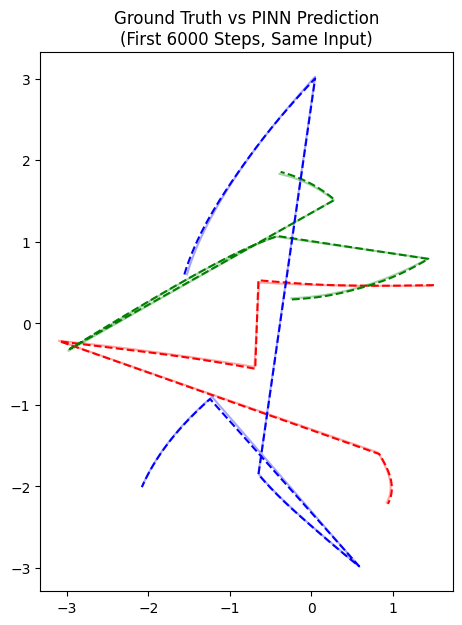

In [7]:
with torch.no_grad():
    X = ds.Xn[:6000]  # normalized true input states
    X = torch.tensor(X, dtype=torch.float32, device=device)
    # move predictions back to CPU and reshape for plotting: [2000, 3, 2]
    pred_direct = net(X).cpu().numpy().reshape(-1,3,2)


# read raw CSV to get ground-truth positions for plotting
df = pd.read_csv("modified_TBP_dataset.csv")
arr = df.values.astype(np.float64)
true_pos = arr[:6000, :6].reshape(-1,3,2)

colors = ['r','g','b']
plt.figure(figsize=(7,7))

for b in range(3):
    # plot ground truth trajectory (faded) and model prediction (dashed)
    plt.plot(true_pos[:,b,0], true_pos[:,b,1], color=colors[b], alpha=0.35)
    plt.plot(pred_direct[:,b,0], pred_direct[:,b,1], color=colors[b], linestyle='--')

# keep equal aspect ratio so orbits are not distorted
plt.gca().set_aspect("equal","box")
plt.title("Ground Truth vs PINN Prediction\n(First 6000 Steps, Same Input)")
plt.show()